# Training Latent Graph Autoencoder

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torchvision
import torch
from torchvision.transforms import Compose, ToTensor, Resize, Scale
from torch.utils.data.dataloader import DataLoader
from graph_autoencoder import LatentGraphVAE
import matplotlib.pyplot as plt
import numpy as np

/home/bglaze/miniconda3/envs/graph_autoencoder/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = 'cuda:1'

In [6]:
transforms = Compose([
    ToTensor(),
    Resize((320//2, 480//2)),
    ])
dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
dataloader = DataLoader(dataset=dataset, batch_size=1)

In [7]:
def l2_overlap_penalty(layers):
    nlayers = layers.shape[0]
    idxs = torch.combinations(torch.arange(nlayers)).to(device)
    overlap = 1 - torch.mean((layers[idxs[:,0]] - layers[idxs[:,1]])**2)
    return overlap

In [8]:
def l1_overlap_penalty(layers):
    nlayers = layers.shape[0]
    idxs = torch.combinations(torch.arange(nlayers)).to(device)
    overlap = 1 - torch.mean(torch.abs(layers[idxs[:,0]] - layers[idxs[:,1]]))
    return overlap

In [58]:
def overlap_penalty(layers):
    nlayers = layers.shape[0]
    idxs = torch.combinations(torch.arange(nlayers)).to(device)
    # TODO this 3 assumes that there are 3 channels. Need to make this a variable
    binned = torch.relu(layers.sum(dim=1))/3
    overlap = torch.mean((binned[idxs[:,0]] * binned[idxs[:,1]]))
    return overlap

In [10]:
def variance_penalty(layers):
    nlayers = layers.shape[0]
    # variance = 1-torch.mean((layers - torch.mean(layers, dim=0).detach())**2)
    variance = 1-torch.mean((torch.amax(layers, dim=1) - torch.amax(torch.mean(layers, dim=0), dim=0))**2)
    return variance

In [11]:
def to_np(tnsr):
    return tnsr.detach().cpu().numpy().transpose((1,2,0))

In [12]:
def l2_penalty(layers):
    return torch.mean(layers**2)

In [13]:
def l1_penalty(layers):
    return torch.mean(torch.abs(layers))

In [14]:
def leaky_clamp(t, a):
    # TODO figure out how to implement this
    pass

In [62]:
lgvae = LatentGraphVAE(n_channels=3, w=320//2, h=480//2, device=device).to(device)
optim = torch.optim.Adam(params=lgvae.parameters())

optim.zero_grad()
batch_size = 100
n_epochs = 1
i=0
batch_loss = 0
batch_variance = 0
batch_overlap = 0
batch_l2 = 0
batch_total = 0
checkpoint = 1000
niter = 100000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, niter//batch_size)

tmstp = '20221201_1342'

image,_ = next(iter(dataloader))
# print(image.shape)

for epoch in range(n_epochs):
    i=0
    # for image,_ in dataloader:
    for j in range(niter):
        image = image.squeeze(0).to(device)
        nodes = lgvae(image)
        # nodes = torch.clamp(nodes, 0,1)
        # nodes = torch.clamp(nodes, 0)
        recon = nodes.amax(dim=(0))
        # recon = nodes.sum(dim=0)
        # midx = torch.argmax(nodes.sum(dim=1), dim=0)
        # recon = torch.gather(nodes, dim=0, index=midx.expand((1,3,-1,-1))).squeeze(0)
        overlap = overlap_penalty(nodes)
        variance = variance_penalty(nodes) 
        l2 = l1_penalty(nodes)
        recon_loss = torch.mean((recon - image)**2) 
        loss = overlap + recon_loss
        loss.backward()
        batch_loss += float(recon_loss)/batch_size
        batch_overlap += float(overlap)/batch_size
        batch_variance += float(variance)/batch_size
        batch_l2 += float(l2)/batch_size
        batch_total += float(loss)/batch_size
        
        i+=1
        if i%batch_size==0:
            optim.step()
            optim.zero_grad()
            lr = scheduler.get_lr()
            print(f"epoch={epoch:4d} n={i:8d} loss={batch_loss:8.4f} " +
                  f"overlap={batch_overlap:8.4f} variance={batch_variance:8.4f} " + 
                #   f"l2={batch_l2:8.4f} total={batch_total}",
                  f"l2={batch_l2:8.4f} lr={lr} total={batch_total}",
             flush=True)
            batch_loss = 0
            batch_overlap = 0
            batch_variance = 0
            batch_l2 = 0
            batch_total = 0
            # scheduler.step()
        # if i%checkpoint==0:
        #     torch.save(lgvae.state_dict(), f'models/lgvae_{tmstp}.torch')

epoch=   0 n=     100 loss=  0.3379 overlap=  0.0000 variance=  1.0000 l2=  0.2004 lr=[0.001] total=0.33791428804397616
epoch=   0 n=     200 loss=  0.3365 overlap=  0.0000 variance=  1.0000 l2=  0.2001 lr=[0.001] total=0.33652612566947887
epoch=   0 n=     300 loss=  0.3349 overlap=  0.0000 variance=  1.0000 l2=  0.1998 lr=[0.001] total=0.33492764830589344
epoch=   0 n=     400 loss=  0.3330 overlap=  0.0000 variance=  1.0000 l2=  0.1995 lr=[0.001] total=0.33296388387680065
epoch=   0 n=     500 loss=  0.3302 overlap=  0.0000 variance=  1.0000 l2=  0.1993 lr=[0.001] total=0.3301652073860168
epoch=   0 n=     600 loss=  0.3255 overlap=  0.0000 variance=  1.0000 l2=  0.1992 lr=[0.001] total=0.3254611492156983
epoch=   0 n=     700 loss=  0.3172 overlap=  0.0000 variance=  1.0000 l2=  0.1993 lr=[0.001] total=0.3171934783458712
epoch=   0 n=     800 loss=  0.3042 overlap=  0.0000 variance=  0.9999 l2=  0.1994 lr=[0.001] total=0.3042257428169252
epoch=   0 n=     900 loss=  0.2873 overlap=

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


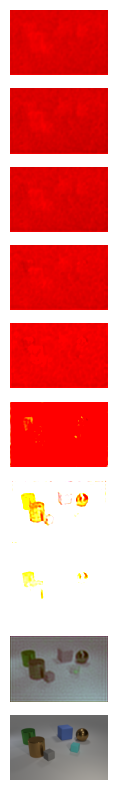

In [64]:
n_nodes = nodes.shape[0]
fig, axs = plt.subplots(n_nodes+2, figsize=(40,10))
for i in range(n_nodes):
    node_np = to_np(nodes[i])
    axs[i].axis('off')
    axs[i].imshow(node_np*8, interpolation='none')
axs[n_nodes].axis('off')
axs[n_nodes].imshow(to_np(recon))
axs[n_nodes+1].axis('off')
axs[n_nodes+1].imshow(to_np(image))

In [ ]:
nodes[:,2,:4,:4]

tensor([[[0.1206, 0.1206, 0.1205, 0.1205],
         [0.1208, 0.1207, 0.1205, 0.1204],
         [0.1207, 0.1207, 0.1207, 0.1205],
         [0.1209, 0.1208, 0.1208, 0.1206]],

        [[0.1207, 0.1213, 0.1216, 0.1214],
         [0.1206, 0.1210, 0.1208, 0.1205],
         [0.1206, 0.1206, 0.1207, 0.1202],
         [0.1207, 0.1207, 0.1208, 0.1206]],

        [[0.1202, 0.1264, 0.1297, 0.1294],
         [0.1196, 0.1279, 0.1291, 0.1280],
         [0.1200, 0.1269, 0.1282, 0.1280],
         [0.1204, 0.1262, 0.1273, 0.1272]],

        [[0.1248, 0.1514, 0.1643, 0.1678],
         [0.1201, 0.1547, 0.1669, 0.1726],
         [0.1212, 0.1594, 0.1691, 0.1749],
         [0.1223, 0.1590, 0.1656, 0.1697]],

        [[0.1344, 0.1916, 0.2196, 0.2287],
         [0.1246, 0.1985, 0.2301, 0.2455],
         [0.1256, 0.2109, 0.2409, 0.2575],
         [0.1263, 0.2120, 0.2377, 0.2521]],

        [[0.1439, 0.2304, 0.2736, 0.2881],
         [0.1296, 0.2414, 0.2925, 0.3170],
         [0.1304, 0.2615, 0.3121, 0.3389],
 

## Validation Set testing

In [ ]:
val_dataset = torchvision.datasets.ImageFolder('data/CLEVR_v1.0/images/train', transform=transforms)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
iter_val_loader = iter(val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


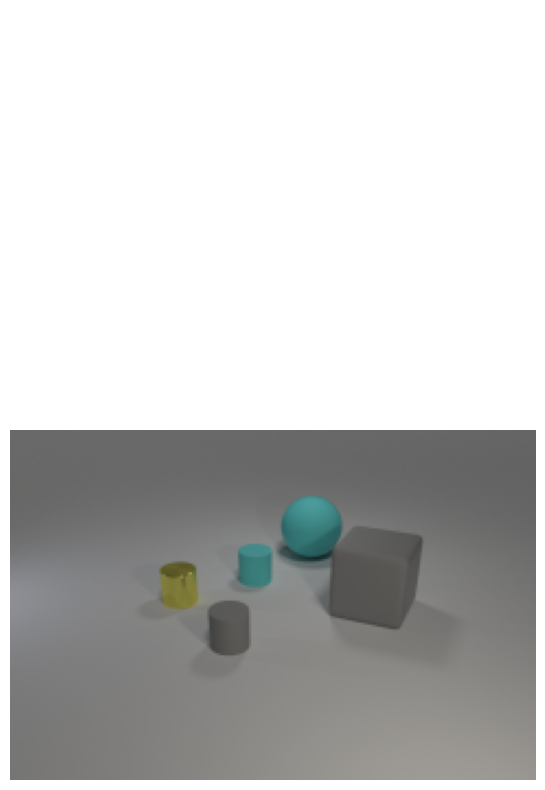

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

with torch.no_grad():
    val_recons = []
    for i in range(10):
        val_image,_ = next(iter_val_loader)
        val_image = val_image.squeeze(0).to(device)
        val_nodes = lgvae(val_image)
        val_recon = val_nodes.sum(dim=0)
        val_nprecon = to_np(val_recon)
        val_recons.append(val_recon)
    # print((val_recons[8] - vala_recons[2]).sum())
    axs[0].axis('off')
    axs[0].imshow(val_nprecon)
    axs[1].axis('off')
    axs[1].imshow(to_np(val_image))